# 1. Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


# 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames)) # 5216
print(len(test_filenames)) # 624
print(len(val_filenames)) # 16 -> 너무 작아 train과 합친 뒤에 다시 8:2로 나눔

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames)) # 4185
print(len(val_filenames)) # 1047

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많음 >>  클래스 불균형(imbalance)

tf.data 인스턴스를 생성.  
tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줌.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# train/val 데이터 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 데이터에 라벨이 없으므로 라벨을 생성.  
라벨은 데이터의 폴더를 통해서 확인 할 수 있음.  


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지의 사이즈를 통일.  
process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경.  
get_label을 이용해서 라벨 값을 가져옴.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다. 
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다.  
num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 resize 확인, label 생성 확인
for image, label in train_ds.take(1): # 하나의 데이터만 불러와서 확인
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# augmentation 없는 코드 
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

origin_train_ds = prepare_for_training(train_ds)
origin_val_ds = prepare_for_training(val_ds)


In [24]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

aug_train_ds = prepare_for_training(train_ds)
aug_val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

original_data 시각화

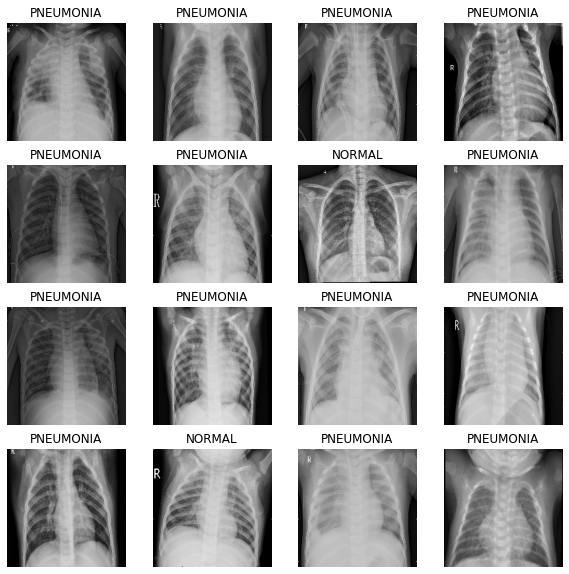

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


origin_image_batch, origin_label_batch = next(iter(origin_train_ds))
show_batch(origin_image_batch.numpy(), origin_label_batch.numpy())

aug_data 시각화

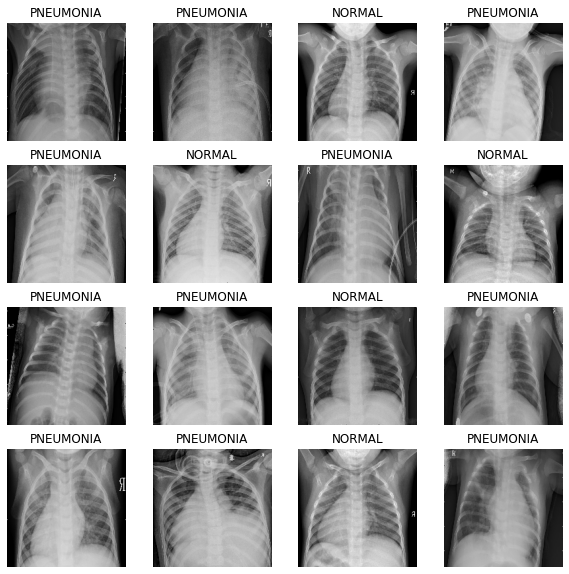

In [25]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


aug_image_batch, aug_label_batch = next(iter(aug_train_ds))
show_batch(aug_image_batch.numpy(), aug_label_batch.numpy())

# 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        origin_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=origin_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 67s 208ms/step - loss: 0.4157 - accuracy: 0.8103 - precision: 0.9506 - recall: 0.7861 - val_loss: 0.6738 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 207ms/step - loss: 0.2220 - accuracy: 0.9167 - precision: 0.9716 - recall: 0.9147 - val_loss: 1.3440 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 209ms/step - loss: 0.2040 - accuracy: 0.9212 - precision: 0.9728 - recall: 0.9200 - val_loss: 0.4178 - val_accuracy: 0.7990 - val_precision: 0.7848 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 55s 212ms/step - loss: 0.1760 - accuracy: 0.9327 - precision: 0.9770 - recall: 0.9314 - val_loss: 0.1007 - val_accuracy: 0.9635 - val_precision: 0.9571 - val_recall: 0.9948
Epoch 5/10
261/261 [==============================] - 56s 216ms/step - loss: 0.1774 - accura

# 7. 결과 확인

origin_data로 학습한 결과

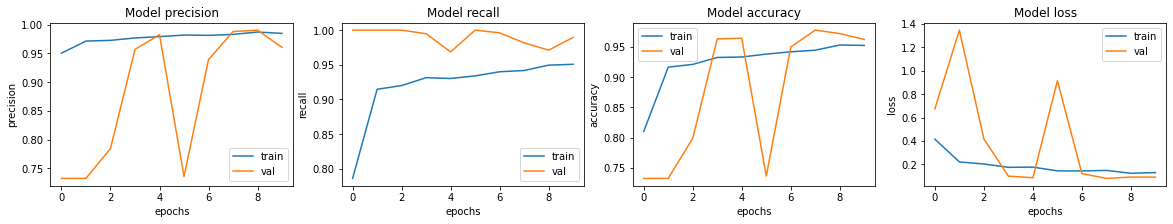

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 120ms/step - loss: 0.8479 - accuracy: 0.7196 - precision: 0.6903 - recall: 1.0000
Loss: 0.847902238368988,
Accuracy: 0.7195512652397156,
Precision: 0.6902654767036438,
Recall: 1.0


aug_data로 학습한 결과

In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        aug_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=aug_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 62s 207ms/step - loss: 0.1490 - accuracy: 0.9418 - precision: 0.9841 - recall: 0.9369 - val_loss: 0.0983 - val_accuracy: 0.9587 - val_precision: 0.9838 - val_recall: 0.9593
Epoch 2/10
261/261 [==============================] - 54s 206ms/step - loss: 0.1342 - accuracy: 0.9519 - precision: 0.9847 - recall: 0.9501 - val_loss: 1.6293 - val_accuracy: 0.5163 - val_precision: 1.0000 - val_recall: 0.3399
Epoch 3/10
261/261 [==============================] - 54s 207ms/step - loss: 0.1483 - accuracy: 0.9401 - precision: 0.9818 - recall: 0.9369 - val_loss: 0.0963 - val_accuracy: 0.9644 - val_precision: 0.9607 - val_recall: 0.9921
Epoch 4/10
261/261 [==============================] - 55s 209ms/step - loss: 0.1248 - accuracy: 0.9516 - precision: 0.9876 - recall: 0.9469 - val_loss: 0.1387 - val_accuracy: 0.9481 - val_precision: 0.9986 - val_recall: 0.9305
Epoch 5/10
261/261 [==============================] - 55s 212ms/step - loss: 0.1164 - accura

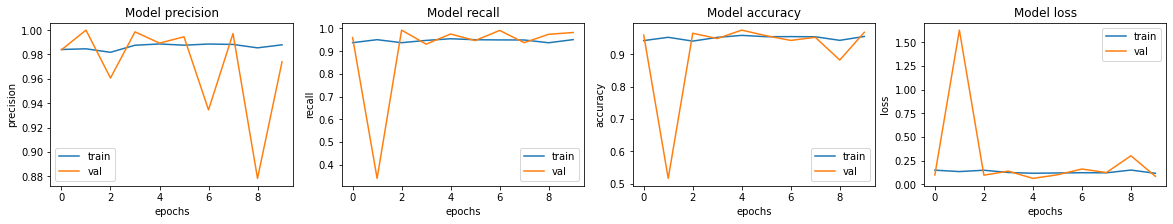

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [29]:
aug_loss, aug_accuracy, aug_precision, aug_recall = model.evaluate(test_ds)
print(f'Loss: {aug_loss},\nAccuracy: {aug_accuracy},\nPrecision: {aug_precision},\nRecall: {aug_recall}')

39/39 [==============================] - 5s 121ms/step - loss: 0.8416 - accuracy: 0.7612 - precision: 0.7269 - recall: 0.9897
Loss: 0.8415515422821045,
Accuracy: 0.7612179517745972,
Precision: 0.7269303202629089,
Recall: 0.9897435903549194


# ResNet

In [101]:
from tensorflow.keras import backend, regularizers, initializers, models, layers

# block 안에 반복적으로 활용되는 L2 regularizer를 선언
def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4): # l2_weight_decay 값이 클수록 정규화 효과가 강해짐
    return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None

In [74]:
# conv_block
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2),
               use_l2_regularizer=True,
               batch_norm_decay=0.9,
               batch_norm_epsilon=1e-5):
    
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(
        filters1, (1, 1),
        use_bias=False,
        kernel_initializer='he_normal', # He 초기화
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '2a')(
            input_tensor)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '2a')(
            x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(
        filters2,
        kernel_size,
        strides=strides,
        padding='same',
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '2b')(
            x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '2b')(
            x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(
        filters3, (1, 1),
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '2c')(
            x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '2c')(
            x)

    shortcut = layers.Conv2D(
        filters3, (1, 1),
        strides=strides,
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '1')(
            input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '1')(
            shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

In [75]:
# Q. identity_block을 가져옵니다.
def identity_block(input_tensor,
                   kernel_size,
                   filters,
                   stage,
                   block,
                   use_l2_regularizer=True,
                   batch_norm_decay=0.9,
                   batch_norm_epsilon=1e-5):

    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(
        filters1, (1, 1),
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '2a')(
            input_tensor)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '2a')(
            x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(
        filters2,
        kernel_size,
        padding='same',
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '2b')(
            x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '2b')(
            x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(
        filters3, (1, 1),
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '2c')(
            x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '2c')(
            x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)

    return x

In [76]:
# resnet50 함수
def resnet50(num_classes,
             batch_size=None,
             use_l2_regularizer=True,
             rescale_inputs=False,
             batch_norm_decay=0.9,
             batch_norm_epsilon=1e-5):
    
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    img_input = layers.Input(shape=input_shape, batch_size=batch_size)

    if backend.image_data_format() == 'channels_first':
        x = layers.Lambda(
            lambda x: backend.permute_dimensions(x, (0, 3, 1, 2)),
            name='transpose')(
                img_input)
        bn_axis = 1
    else:  # channels_last
        x = img_input
        bn_axis = 3

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = layers.Conv2D(
        64, (7, 7),
        strides=(2, 2),
        padding='valid',
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name='conv1')(
            x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name='bn_conv1')(
            x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = conv_block(
        x,
        3, [64, 64, 256],
        stage=2,
        block='a',
        strides=(1, 1),
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [64, 64, 256],
        stage=2,
        block='b',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [64, 64, 256],
        stage=2,
        block='c',
        use_l2_regularizer=use_l2_regularizer)

    x = conv_block(
        x,
        3, [128, 128, 512],
        stage=3,
        block='a',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [128, 128, 512],
        stage=3,
        block='b',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [128, 128, 512],
        stage=3,
        block='c',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [128, 128, 512],
        stage=3,
        block='d',
        use_l2_regularizer=use_l2_regularizer)

    x = conv_block(
        x,
        3, [256, 256, 1024],
        stage=4,
        block='a',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [256, 256, 1024],
        stage=4,
        block='b',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [256, 256, 1024],
        stage=4,
        block='c',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [256, 256, 1024],
        stage=4,
        block='d',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [256, 256, 1024],
        stage=4,
        block='e',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [256, 256, 1024],
        stage=4,
        block='f',
        use_l2_regularizer=use_l2_regularizer)

    x = conv_block(
        x,
        3, [512, 512, 2048],
        stage=5,
        block='a',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [512, 512, 2048],
        stage=5,
        block='b',
        use_l2_regularizer=use_l2_regularizer)
    x = identity_block(
        x,
        3, [512, 512, 2048],
        stage=5,
        block='c',
        use_l2_regularizer=use_l2_regularizer)

    rm_axes = [1, 2] if backend.image_data_format() == 'channels_last' else [2, 3]
    x = layers.Lambda(lambda x: backend.mean(x, rm_axes), name='reduce_mean')(x)
    x = layers.Dense(
        num_classes,
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name='fc1000')(
            x)

    x = layers.Activation('softmax', dtype='float32')(x) # sigmoid로 변환하면 다른 결과값이 나올까? 흠..

    return models.Model(img_input, x, name='resnet50')

In [77]:
model = resnet50(num_classes=1)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 90, 90, 64)   9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 90, 90, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [78]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [79]:
with tf.device('/GPU:0'):
    #model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [80]:
with tf.device('/GPU:0'):
    history = model.fit(
        aug_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=aug_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 74s 231ms/step - loss: 4.3658 - accuracy: 0.7440 - precision: 0.7440 - recall: 1.0000 - val_loss: 3.0205 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 59s 227ms/step - loss: 2.3397 - accuracy: 0.7450 - precision: 0.7450 - recall: 1.0000 - val_loss: 2.3706 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 60s 229ms/step - loss: 1.4936 - accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - val_loss: 1.4220 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 60s 229ms/step - loss: 1.1182 - accuracy: 0.7440 - precision: 0.7440 - recall: 1.0000 - val_loss: 1.1017 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 60s 230ms/step - loss: 0.8576 - accura

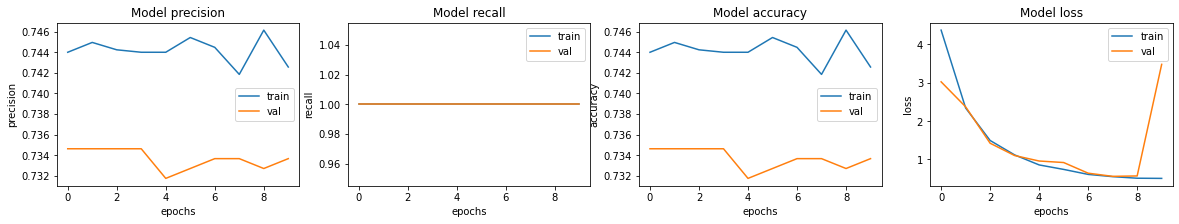

In [81]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [82]:
aug_res_loss, aug_res_accuracy, aug_res_precision, aug_res_recall = model.evaluate(test_ds)
print(f'Loss: {aug_res_loss},\nAccuracy: {aug_res_accuracy},\nPrecision: {aug_res_precision},\nRecall: {aug_res_recall}')

39/39 [==============================] - 5s 125ms/step - loss: 3.8978 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 3.8978283405303955,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


## Resnet18

In [102]:
def conv_block_res18(input_tensor,
                   kernel_size,
                   filters,
                   stage,
                   block,
                   strides=(2, 2),
                   use_l2_regularizer=True,
                   batch_norm_decay=0.9,
                   batch_norm_epsilon=1e-5):
    filters1, filters2 = filters  # ResNet18에서는 필터 수가 2개로만 정의됨

    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(
        filters1, kernel_size,
        strides=strides,
        padding='same',
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '2a'
    )(input_tensor)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '2a'
    )(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(
        filters2,
        kernel_size,
        padding='same',
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '2b'
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '2b'
    )(x)
    x = layers.Activation('relu')(x)

    shortcut = layers.Conv2D(
        filters2, (1, 1),
        strides=strides,
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '1'
    )(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '1'
    )(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def identity_block_res18(input_tensor,
                       kernel_size,
                       filters,
                       stage,
                       block,
                       use_l2_regularizer=True,
                       batch_norm_decay=0.9,
                       batch_norm_epsilon=1e-5):
    filters1, filters2 = filters  # ResNet18에서는 필터 수가 2개로만 정의됨

    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(
        filters1, (1, 1),
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '2a'
    )(input_tensor)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '2a'
    )(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(
        filters2,
        kernel_size,
        padding='same',
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name=conv_name_base + '2b'
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name=bn_name_base + '2b'
    )(x)
    x = layers.Activation('relu')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)

    return x

def resnet18(num_classes,
             batch_size=None,
             use_l2_regularizer=True,
             rescale_inputs=False,
             batch_norm_decay=0.9,
             batch_norm_epsilon=1e-5):
    
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    img_input = layers.Input(shape=input_shape, batch_size=batch_size)

    if backend.image_data_format() == 'channels_first':
        x = layers.Lambda(
            lambda x: backend.permute_dimensions(x, (0, 3, 1, 2)),
            name='transpose'
        )(img_input)
        bn_axis = 1
    else:  # channels_last
        x = img_input
        bn_axis = 3

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
    x = layers.Conv2D(
        64, (7, 7),
        strides=(2, 2),
        padding='valid',
        use_bias=False,
        kernel_initializer='he_normal',
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name='conv1'
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=batch_norm_decay,
        epsilon=batch_norm_epsilon,
        name='bn_conv1'
    )(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = conv_block_res18(
        x,
        3, [64, 64],
        stage=2,
        block='a',
        strides=(1, 1),
        use_l2_regularizer=use_l2_regularizer
    )
    x = identity_block_res18(
        x,
        3, [64, 64],
        stage=2,
        block='b',
        use_l2_regularizer=use_l2_regularizer
    )
    x = identity_block_res18(
        x,
        3, [64, 64],
        stage=2,
        block='c',
        use_l2_regularizer=use_l2_regularizer
    )

    x = conv_block_res18(
        x,
        3, [128, 128],
        stage=3,
        block='a',
        use_l2_regularizer=use_l2_regularizer
    )
    x = identity_block_res18(
        x,
        3, [128, 128],
        stage=3,
        block='b',
        use_l2_regularizer=use_l2_regularizer
    )
    x = identity_block_res18(
        x,
        3, [128, 128],
        stage=3,
        block='c',
        use_l2_regularizer=use_l2_regularizer
    )
    x = identity_block_res18(
        x,
        3, [128, 128],
        stage=3,
        block='d',
        use_l2_regularizer=use_l2_regularizer
    )

    x = conv_block_res18(
        x,
        3, [256, 256],
        stage=4,
        block='a',
        use_l2_regularizer=use_l2_regularizer
    )
    x = identity_block_res18(
        x,
        3, [256, 256],
        stage=4,
        block='b',
        use_l2_regularizer=use_l2_regularizer
    )
    x = identity_block_res18(
        x,
        3, [256, 256],
        stage=4,
        block='c',
        use_l2_regularizer=use_l2_regularizer
    )
    x = identity_block_res18(
        x,
        3, [256, 256],
        stage=4,
        block='d',
        use_l2_regularizer=use_l2_regularizer
    )
    
    x = conv_block_res18(
        x,
        3, [512, 512],
        stage=5,
        block='a',
        use_l2_regularizer=use_l2_regularizer
    )
    x = identity_block_res18(
        x,
        3, [512, 512],
        stage=5,
        block='b',
        use_l2_regularizer=use_l2_regularizer
    )
    x = identity_block_res18(
        x,
        3, [512, 512],
        stage=5,
        block='c',
        use_l2_regularizer=use_l2_regularizer
    )

    rm_axes = [1, 2] if backend.image_data_format() == 'channels_last' else [2, 3]
    x = layers.Lambda(lambda x: backend.mean(x, rm_axes), name='reduce_mean')(x)
    x = layers.Dense(
        num_classes,
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name='fc1000'
    )(x)

    x = layers.Activation('softmax', dtype='float32')(x)

    return models.Model(img_input, x, name='resnet18')


In [103]:
model = resnet18(num_classes=1)

model.summary()

Model: "resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 90, 90, 64)   9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 90, 90, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [104]:
with tf.device('/GPU:0'):
    #model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [105]:
with tf.device('/GPU:0'):
    history = model.fit(
        aug_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=aug_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 66s 211ms/step - loss: 1.3322 - accuracy: 0.7440 - precision: 0.7440 - recall: 1.0000 - val_loss: 1.0538 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 207ms/step - loss: 0.7943 - accuracy: 0.7443 - precision: 0.7443 - recall: 1.0000 - val_loss: 1.3617 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 208ms/step - loss: 0.5555 - accuracy: 0.7440 - precision: 0.7440 - recall: 1.0000 - val_loss: 0.6085 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 55s 211ms/step - loss: 0.4524 - accuracy: 0.7447 - precision: 0.7447 - recall: 1.0000 - val_loss: 6.6290 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 56s 213ms/step - loss: 0.4350 - accura

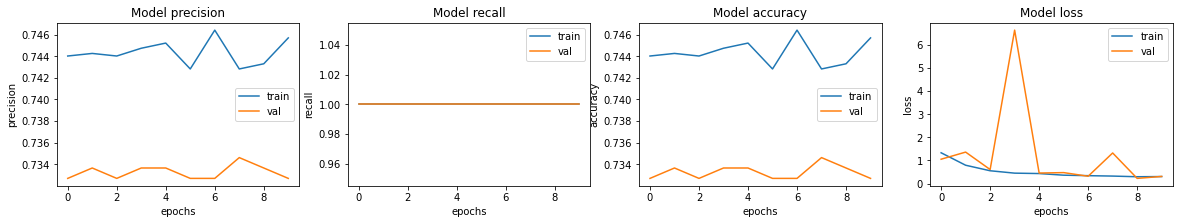

In [106]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [107]:
aug_res18_loss, aug_res18_accuracy, aug_res18_precision, aug_res18_recall = model.evaluate(test_ds)
print(f'Loss: {aug_res18_loss},\nAccuracy: {aug_res18_accuracy},\nPrecision: {aug_res18_precision},\nRecall: {aug_res18_recall}')

39/39 [==============================] - 5s 125ms/step - loss: 1.5760 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.5760250091552734,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# transfer learning

In [61]:
from tensorflow.keras.applications import ResNet50

# include_top=False로 설정하면, 분류기를 제외한 모델의 합성곱 기반만 불러오기
# imagenet에서 학습된 가중치 가져오기
resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')

resnet_base_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 90, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1_conv[0][0]                 
__________________________

In [65]:
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
resnet_model = tf.keras.Sequential([
    resnet_base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.6),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1,activation="sigmoid")
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [66]:
with tf.device('/GPU:0'):
    history = resnet_model.fit(
        aug_train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=aug_val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 74s 231ms/step - loss: 0.3539 - accuracy: 0.8472 - precision: 0.9577 - recall: 0.8314 - val_loss: 1.0938 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 59s 224ms/step - loss: 0.2241 - accuracy: 0.9126 - precision: 0.9718 - recall: 0.9091 - val_loss: 1.0897 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 59s 224ms/step - loss: 0.1976 - accuracy: 0.9212 - precision: 0.9773 - recall: 0.9153 - val_loss: 1.2639 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 59s 225ms/step - loss: 0.1715 - accuracy: 0.9325 - precision: 0.9816 - recall: 0.9267 - val_loss: 0.3748 - val_accuracy: 0.9048 - val_precision: 0.8989 - val_recall: 0.9803
Epoch 5/10
261/261 [==============================] - 60s 229ms/step - loss: 0.1642 - accura

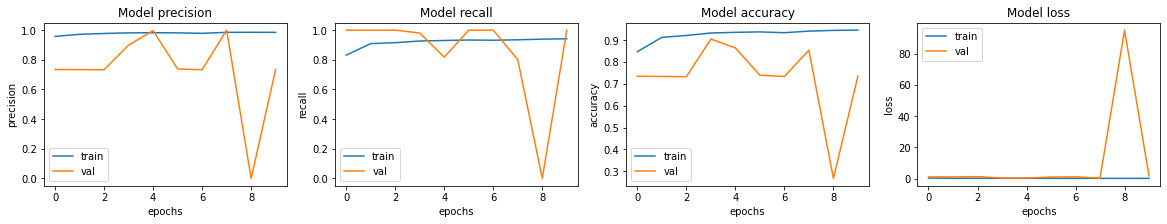

In [67]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [70]:
aug_res_tf_loss, aug_res_tf_accuracy, aug_res_tf_precision, aug_res_tf_recall = resnet_model.evaluate(test_ds)
print(f'Loss: {aug_res_tf_loss},\nAccuracy: {aug_res_tf_accuracy},\nPrecision: {aug_res_tf_precision},\nRecall: {aug_res_tf_recall}')

39/39 [==============================] - 5s 134ms/step - loss: 2.4106 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 2.410614252090454,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# 결과값 정리

In [108]:
import pandas as pd

# 결과값을 딕셔너리로 저장
results_dict = {
    'Original with CNN': [loss, accuracy, precision, recall],
    'Augmented with CNN': [aug_loss, aug_accuracy, aug_precision, aug_recall],
    'Augmented with ResNet50': [aug_res_loss, aug_res_accuracy, aug_res_precision, aug_res_recall],
    'Augmented with ResNet50(tf)' : [aug_res_tf_loss, aug_res_tf_accuracy, aug_res_tf_precision, aug_res_tf_recall],
    'Augmented with ResNet18' : [aug_res18_loss, aug_res18_accuracy, aug_res18_precision, aug_res18_recall]
}

# 딕셔너리를 데이터프레임으로 변환
results_df = pd.DataFrame(results_dict, index=['Loss', 'Accuracy', 'Precision', 'Recall'])

results_df

,Original with CNN,Augmented with CNN,Augmented with ResNet50,Augmented with ResNet50(tf),Augmented with ResNet18
Loss,0.847902,0.841552,3.897828,2.410614,1.576025
Accuracy,0.719551,0.761218,0.625000,0.625000,0.625000
Precision,0.690265,0.726930,0.625000,0.625000,0.625000
Recall,1.000000,0.989744,1.000000,1.000000,1.000000


# 회고

### 느낀점

* 그 동안 배운 것들에 대해서 복습할 수 있는 좋은 시간이었다.
* Resnet50인 줄 알고 진행하다가 마지막에 Resnet18인 것을 알고, filter 를 수정해서 비교한 실험을 진행하게 되었다.
* 직접 구현한 것과 keras에서 Resnet50을 불러서 진행했을 때 모델의 성능 결과가 loss값에서 차이가 있었지만 acc, precision에서 동일하게 나와서 신기했다. 
* 시간이 나면 다른 augmentation 방법,다양한 모델들과 하이퍼파리미터를 조절하여 어떻게 변하는지 확인해보고 싶고, XAI를 적용해서 어느 부분이 모델의 학습에 영향을 미쳤는지 확인해보고 싶다. 

* 여러모로 유익한 시간을 보내게 해주셔서 감사합니다 :) 

### reference

[Medical Diagnosis with CNN& Transfer Learning]   
https://www.kaggle.com/code/homayoonkhadivi/medical-diagnosis-with-cnn-transfer-learning#Transfer-Learning